In [1]:
import os
import numpy as np
import torch
import glob
from PIL import Image
import cv2
import manga109api
import torchvision
from torchvision import transforms
from src.model import EfficientDet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import easyocr

In [2]:
PATH = "mangadet.pth"

In [3]:
model = EfficientDet(num_classes = 2).cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientDet(
  (conv3): Conv2d(40, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(80, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv6): Conv2d(192, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
          (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (2): BatchNorm2d(64, eps=4e-05, momentum=0.9997, affine=True, track_running_stats=True)
          (3): ReLU()
        )
      )
      (conv5_up): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
          (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
 

In [4]:
image_base_path = "F:\\Datasets\\Manga109\\images\\"
manga109_root_dir = "F:\\Datasets\\Manga109"
p = manga109api.Parser(root_dir=manga109_root_dir)

In [5]:
book = "ARMS"
image_full_path = image_base_path + book + '\\'
annotation = p.get_annotation(book=book)

In [6]:
page_index = 19
img = cv2.imread(p.img_path(book=book, index=page_index))
#img = cv2.imread("5.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
img = img.astype(np.float32) / 255.
img = torch.from_numpy(img).unsqueeze(0)
img = img.permute(0, 3, 1, 2).double().cuda()

In [7]:
with torch.no_grad():
    out = model(img)

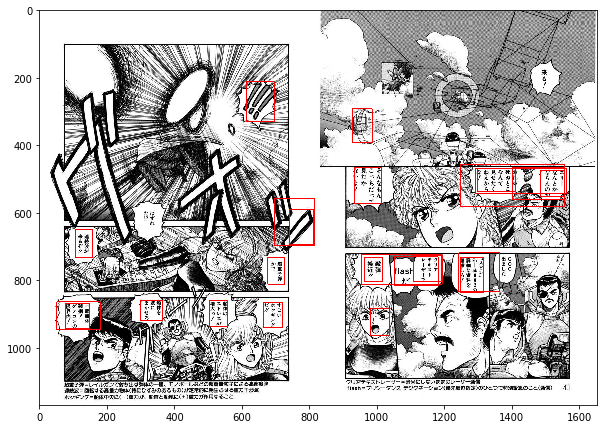

In [11]:
img = cv2.imread(p.img_path(book=book, index=page_index))
#img = cv2.imread("5.jpg")

width, height, _ = img.shape
h_scale, w_scale = width/512, height/512
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, (512,512))
for score, co in zip(out[0], out[2]):
    if score < 0.1:
        continue
    color = (255, 0, 0)
    thickness = 2
    start_point = (int(co[0] * w_scale) , int(co[1] * h_scale))
    end_point = (int(co[2] * w_scale), int(co[3] * h_scale))
    img = cv2.rectangle(img, start_point, end_point, color, thickness)
plt.figure(figsize=(10,12)) 
plt.imshow(img)

In [12]:
cv2.imwrite("out_efficientdet.png", img)

True

In [10]:
out[0]

tensor([0.9547, 0.9328, 0.9210, 0.8183, 0.8135, 0.8096, 0.7738, 0.7727, 0.5611,
        0.5248, 0.1598, 0.1553, 0.1540, 0.1469, 0.1405, 0.1353, 0.1335, 0.1292,
        0.1272, 0.1258, 0.1216, 0.1196, 0.1156, 0.1051, 0.0963, 0.0962, 0.0956,
        0.0892, 0.0783, 0.0772, 0.0721, 0.0714, 0.0709, 0.0706, 0.0702, 0.0702,
        0.0695, 0.0678, 0.0673, 0.0666, 0.0651, 0.0641, 0.0635, 0.0624, 0.0618,
        0.0611, 0.0609, 0.0597, 0.0592, 0.0585, 0.0580, 0.0577, 0.0575, 0.0572,
        0.0565, 0.0561, 0.0561, 0.0561, 0.0557, 0.0553, 0.0551, 0.0546, 0.0535,
        0.0535, 0.0519, 0.0515, 0.0505, 0.0503, 0.0501], device='cuda:0',
       dtype=torch.float64)